Удалила "2 Зрелый почерк-(обычный почерк)-2.jpg" (там печатный текст)

# Config

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/Colab\ Notebooks/mest

/content/drive/MyDrive/Colab Notebooks/mest


In [3]:
# FOLDER = "images"

# OLD_TRAIN_DIR = f"{FOLDER}/Жуковский образцы почерка"
# TRAIN_DIR = f"{FOLDER}/train"

# OLD_TEST_DIR = f"{FOLDER}/Конволюты"
# TEST_DIR = f"{FOLDER}/test"

# NEW_TRAIN_DIR = f"{FOLDER}/new_train"
# NEW_TEST_DIR = f"{FOLDER}/new_test"
# IMG_SIZE = (3024, 4032)

DATA = "data"
DATA_POS = f"{DATA}/1"
DATA_NEG = f"{DATA}/0"

BATCH_SIZE = 8
PATH = "m.pth"
import torch
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score
from torchvision import datasets, models, transforms

from src.functions import *
from src.dataset import *
from src.train import *


print(f"{DEVICE = }")

DEVICE = device(type='cuda')


In [4]:
# seed_everything(42)
"seed_everything(42)"

'seed_everything(42)'

# torchvision.transforms

In [5]:
data_transform = transforms.Compose([
    # transforms.Resize(size=(224, 224)),
    transforms.RandomCrop(300),
    # Flip the images randomly on the horizontal
    # transforms.RandomHorizontalFlip(p=1), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])


# tranf = transforms.Compose([
#         # transforms.Resize(256), # размер каждой картинки будет приведен к 256*256
#         # transforms.CenterCrop(224), # у картинки будет вырезан центральный кусок размера 224*224
#         transforms.RandomCrop(224)
#         # transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
#         transforms.ToTensor(), # картинка из питоновского массива переводится в формат torch.Tensor
#         # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # значения пикселей картинки нормализуются
#     ])

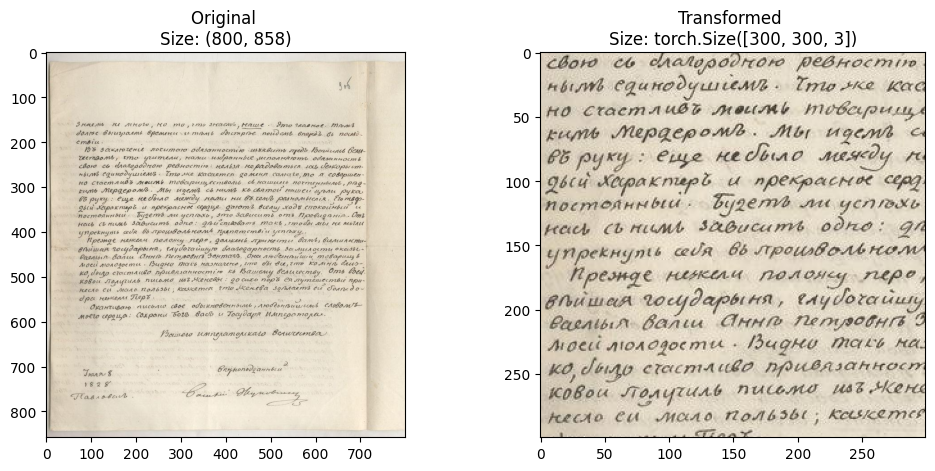

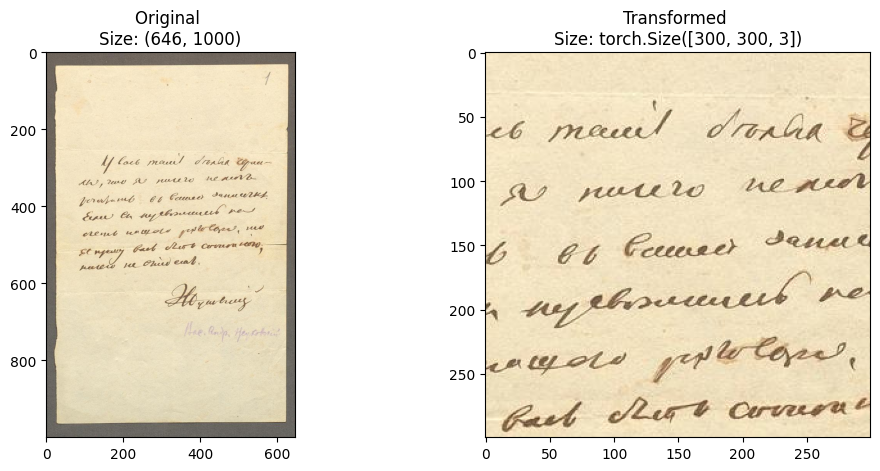

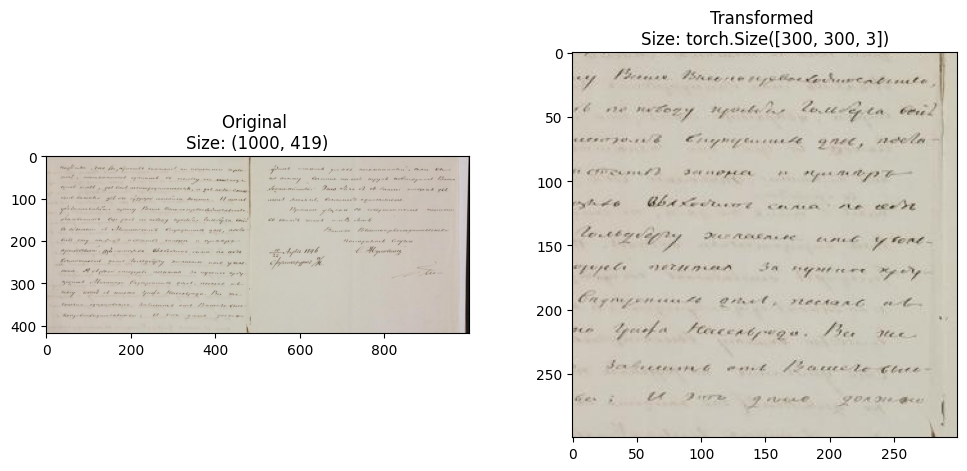

In [6]:
files_names = sorted(os.listdir(DATA_POS))
image_paths  = [os.path.join(DATA_POS, i) for i in files_names]

plot_transformed_images(image_paths, transform=data_transform)

# Dataset

In [7]:
# https://stackoverflow-com.translate.goog/questions/51677788/data-augmentation-in-pytorch?_x_tr_sl=auto&_x_tr_tl=ru&_x_tr_hl=ru

# class experimental_dataset(Dataset):
#     def __init__(self, data, transform):
#         self.data = data
#         self.transform = transform

#     def __len__(self):
#         return len(self.data.shape[0])

#     def __getitem__(self, idx):
#         item = self.data[idx]
#         item = self.transform(item)
#         return item

# transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor()
# ])

# x = torch.rand(8, 1, 2, 2)
# print(x)

# dataset = experimental_dataset(x, transform)

# for item in dataset:
#     print(item)


In [8]:
# data_transform = transforms.Compose([
#     transforms.RandomCrop(300),
# ])

pos_dataset = Positive_Dataset(DATA_POS, augmentation=11, transform=data_transform)
print(f"Positive: {len(pos_dataset)}    ({pos_dataset.real_len})")

neg_dataset = Negative_Dataset(DATA_NEG, augmentation=1, transform=data_transform)
print(f"Negative: {len(neg_dataset)}    ({neg_dataset.real_len})")

dataset = torch.utils.data.ConcatDataset([pos_dataset, neg_dataset]) # подряд идут 1, потом 0
print(f"ConcatDataset: {len(dataset)}")

Positive: 242    (22)
Negative: 224    (224)
ConcatDataset: 466


In [9]:
# в тренировочную выборку отнесем 80% всех картинок

train_size = int(len(dataset) * 0.8)
# в валидационную — остальные 20%
val_size = len(dataset) - train_size

seed_everything(42)
train_dataset, test_dataset = torch.utils.data.random_split(
                    dataset, [train_size, val_size])

print(f"Train: {len(train_dataset)}\n Test: {len(test_dataset)}")

Train: 372
 Test: 94


In [10]:
# first = train_dataset[0]
# print(first[0].shape, first[1])
# print(first[0][:, :3, :3])

# Dataloader

In [11]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                          shuffle=False)

print(f"Train batches: {len(train_loader)}\n Test batches: {len(test_loader)}")

Train batches: 47
 Test batches: 12


torch.Size([8, 3, 300, 300]) tensor([0, 1, 1, 0, 0, 0, 0, 1])


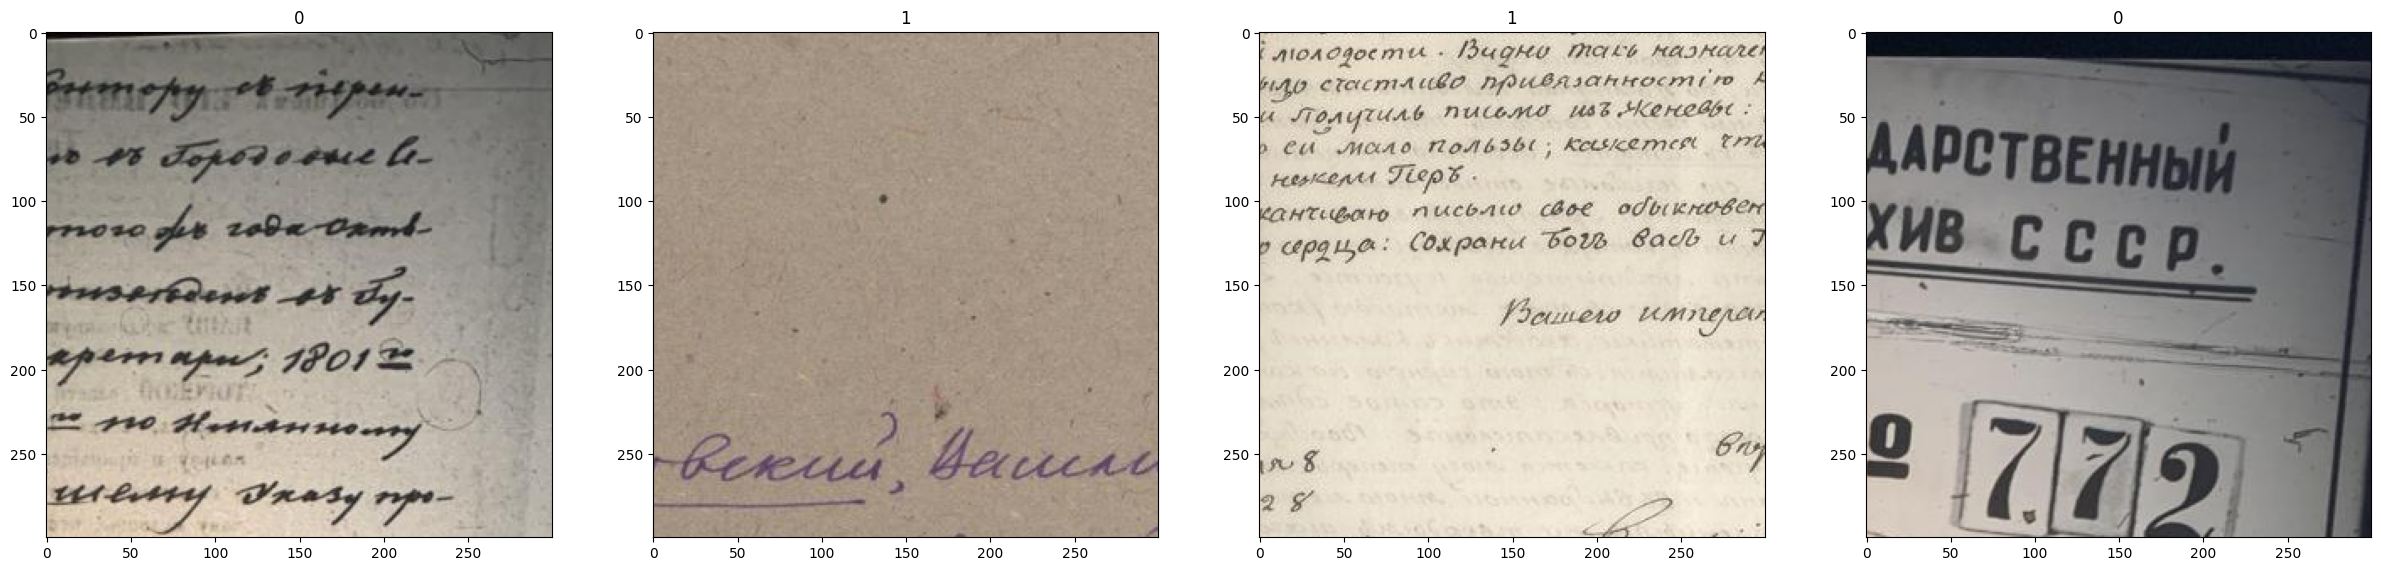

In [12]:
images, labels = next(iter(test_loader))
print(images.shape, labels)
show_images(images, labels)

torch.Size([8, 3, 300, 300]) tensor([0, 1, 1, 0, 0, 0, 0, 1])


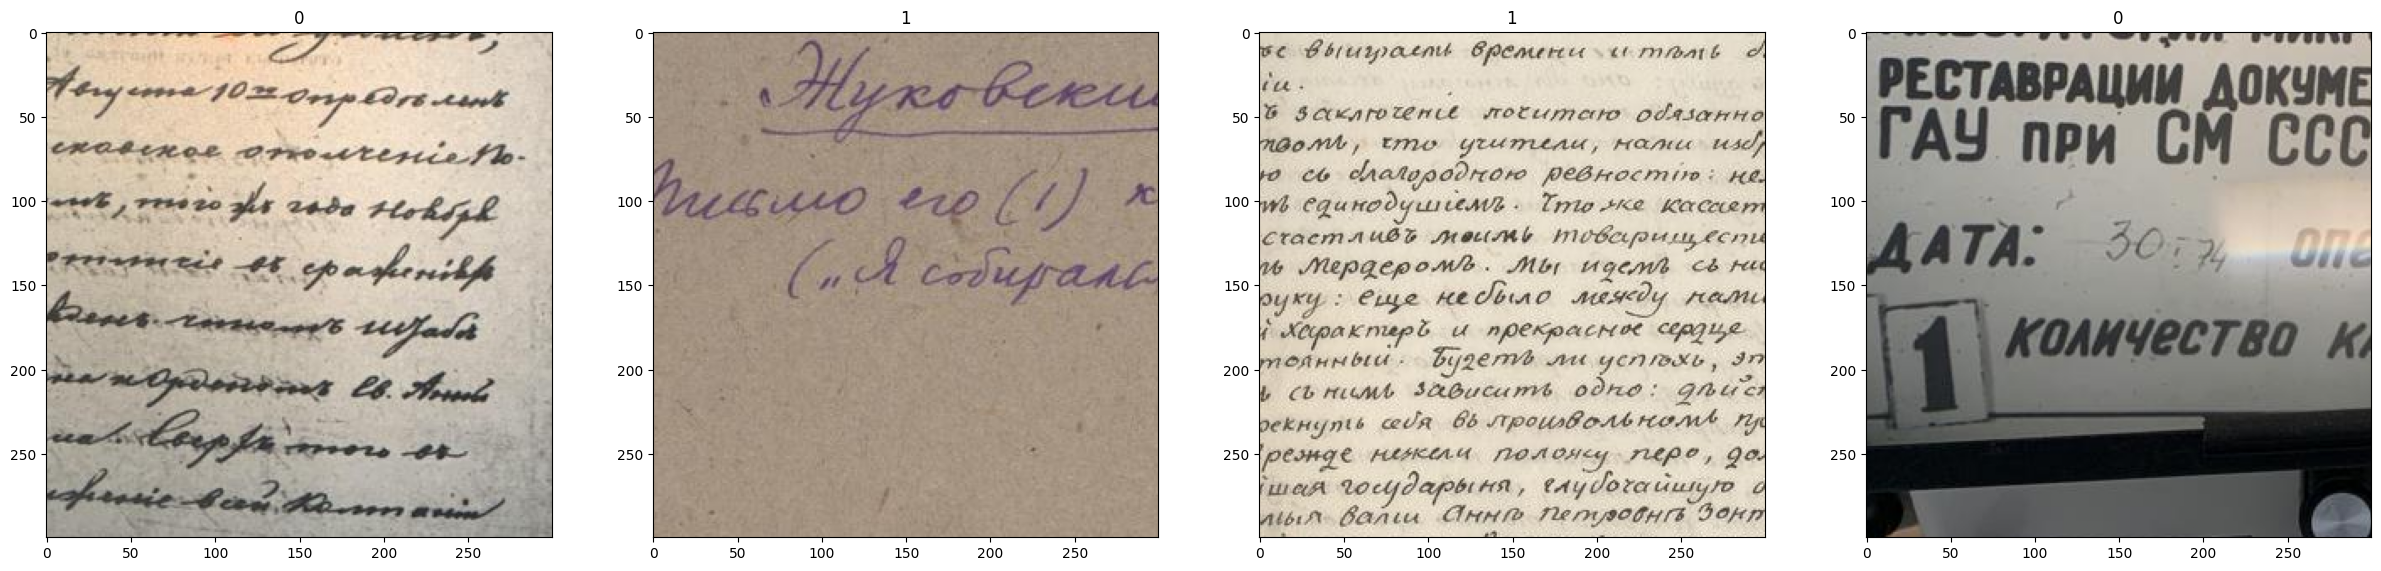

In [13]:
images, labels = next(iter(test_loader))
print(images.shape, labels)
show_images(images, labels)

# freeze_layers

In [14]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
# list(model.children())
# dir(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 87.6MB/s]


In [15]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [16]:
num_layers = len(list(model.children()))
print(f"Число слоёв: {num_layers}")
num_classes = 2
print(f"Число классов: {num_classes}")

model = create_model(model, num_layers - 1, num_classes).to(DEVICE)

Число слоёв: 10
Число классов: 2


In [17]:
model.fc

Linear(in_features=512, out_features=2, bias=True)

In [18]:
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

# train

In [19]:
%time
# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate.
# вы можете экспериментировать с разными значениями learning_rate
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# запустим обучение модели
# параметр n_epoch можно варьировать
model = train(model, train_loader, test_loader, loss_fn, optimizer, n_epoch=5)
torch.save(model.state_dict(), PATH)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs
Epoch: 1
Эпоха 1/5: val лосс и accuracy: 0.3575231631596883 0.9361702
Epoch: 2
Эпоха 2/5: val лосс и accuracy: 0.31804947430888814 0.9468085
Epoch: 3
Эпоха 3/5: val лосс и accuracy: 0.309937817354997 0.9680851
Epoch: 4
Эпоха 4/5: val лосс и accuracy: 0.3113517500460148 0.9468085
Epoch: 5
Эпоха 5/5: val лосс и accuracy: 0.2753332902987798 0.9574468


# Код визуализации

In [20]:
def show_images(images, labels, n = 4):
    # f, axes= plt.subplots(n//4, 4, figsize=(30,10))


    num_pic = min(len(images), n)
    width, height = 4, num_pic // 4 + 1

    # plt.figure(figsize=(6.4 * width, 6))

    for i in range(num_pic):

        if i % width == 0:
            plt.figure(figsize=(6.4 * width, 6))

        # plt.subplot(height, width, i + 1)
        plt.subplot(1, width, i % width + 1)

        img = images[i]
        img = np.transpose(img, (1, 2, 0))

        plt.imshow(img)
        if torch.is_tensor(labels[i]):
            plt.title(labels[i].numpy())
        else:
            plt.title(labels[i])

        if i % width == width - 1:
            plt.tight_layout()
            plt.show()

    plt.show()

In [21]:
def show_result(model, dataset, threshold, greater = True, col = 8, seed = 42, sort = False):
    seed_everything(seed)

    loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                           shuffle=False)

    y_pred, y_true, y_prob, X = get_predictions(model, loader)

    if sort:
        s, indices = torch.sort(y_prob)
        y_pred = y_pred[indices]
        y_prob = y_prob[indices]
        X = X[indices]

    if greater:
        idx = np.where(y_prob > threshold)[0]
    else:
        idx = np.where(y_prob < threshold)[0]


    sign = ">" if greater else "<"
    print(f"prob {sign} {threshold}\ncount : {len(idx)} out of {len(dataset)}")
    idx = idx[:col]
    print(f"pic idx : {list(idx)}")
    show_images(X[idx], y_prob[idx], n = col)

    return y_pred, y_true, y_prob, X

# eval

In [22]:
y_pred, y_true, y_prob, _ = get_predictions(model, train_loader)
accuracy_score(y_pred, y_true)

0.946236559139785

In [23]:
y_pred, y_true, y_prob, _ = get_predictions(model, train_loader)
accuracy_score(y_pred, y_true)

0.9327956989247311

In [24]:
seed_everything(42)
y_pred, y_true, y_prob, _ = get_predictions(model, train_loader)
accuracy_score(y_pred, y_true)

0.9489247311827957

In [25]:
seed_everything(42)
y_pred, y_true, y_prob, _ = get_predictions(model, train_loader)
accuracy_score(y_pred, y_true)

0.9489247311827957

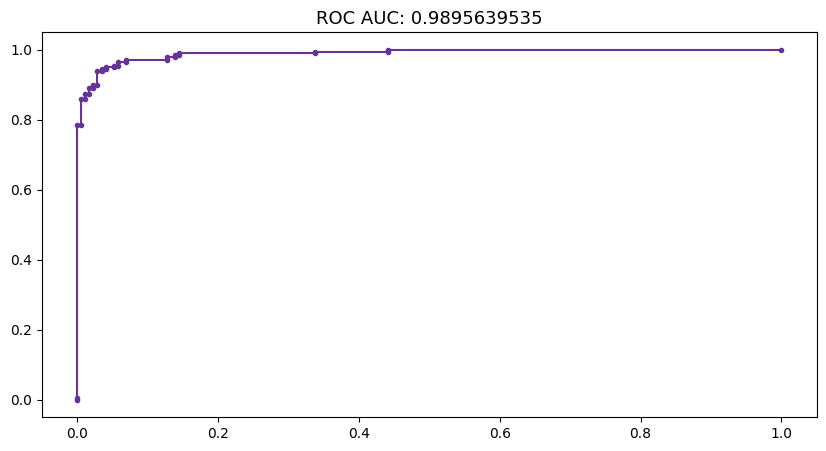

In [26]:
fpr, tpr, thresholds = roc_curve(y_true, y_prob)

plt.figure(figsize=(10, 5))
plt.title(f"ROC AUC: {roc_auc_score(y_true, y_prob):.10}", fontsize=13)
plt.plot(fpr, tpr, marker='.', color = 'rebeccapurple')
plt.show()

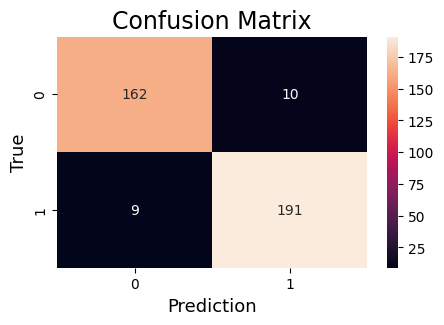

array([[162,  10],
       [  9, 191]])

In [27]:
confusion_matrix(y_true, y_pred)

In [28]:
seed_everything(42)
y_pred, y_true, y_prob, _ = get_predictions(model, test_loader)
accuracy_score(y_pred, y_true)

0.9893617021276596

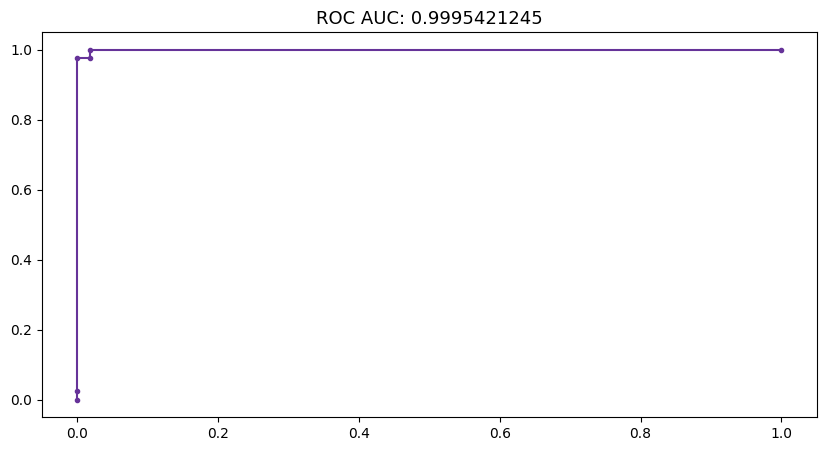

In [29]:
fpr, tpr, thresholds = roc_curve(y_true, y_prob)

plt.figure(figsize=(10, 5))
plt.title(f"ROC AUC: {roc_auc_score(y_true, y_prob):.10}", fontsize=13)
plt.plot(fpr, tpr, marker='.', color = 'rebeccapurple')
plt.show()

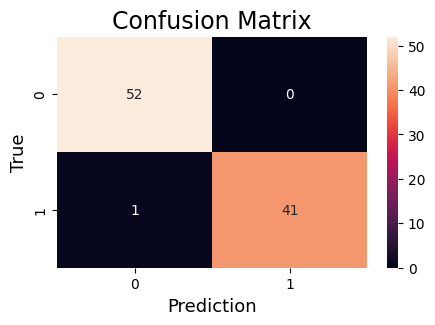

array([[52,  0],
       [ 1, 41]])

In [30]:
confusion_matrix(y_true, y_pred)

# show

In [31]:
# seed_everything(42)
# loader = torch.utils.data.DataLoader(pos_dataset, batch_size=BATCH_SIZE,
#                                            shuffle=False)


# images, labels = next(iter(loader))
# print(images.shape, labels)
# show_images(images, labels)

In [32]:
# seed_everything(42)
# pos_loader = torch.utils.data.DataLoader(pos_dataset, batch_size=BATCH_SIZE,
#                                            shuffle=True)

# y_pred_pos, y_true_pos, y_prob_pos, X_pos = get_predictions(model, pos_loader)
# accuracy_score(y_pred_pos, y_true_pos)

In [33]:
# (y_prob > 0.5).float() == y_pred

(0.0, 1.0)

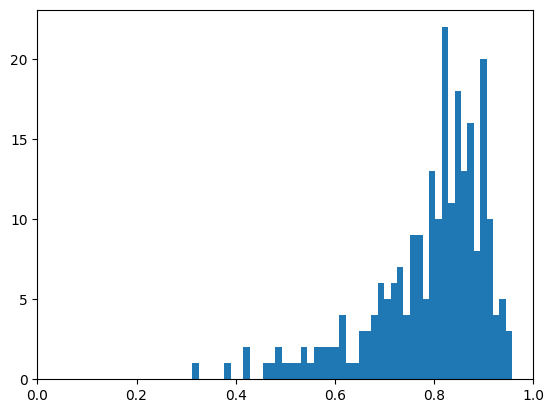

In [34]:
seed_everything(42)
pos_loader = torch.utils.data.DataLoader(pos_dataset, batch_size=BATCH_SIZE,
                                           shuffle=False)

y_pred, y_true, y_prob, _ = get_predictions(model, pos_loader)
_ = plt.hist(y_prob.numpy(), bins = 50)
plt.xlim((0,1))

(0.0, 1.0)

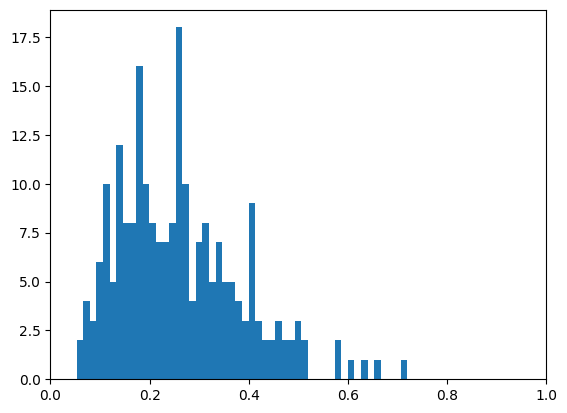

In [35]:
seed_everything(42)
neg_loader = torch.utils.data.DataLoader(neg_dataset, batch_size=BATCH_SIZE,
                                           shuffle=False)

y_pred, y_true, y_prob, _ = get_predictions(model, neg_loader)
_ = plt.hist(y_prob.numpy(), bins = 50)
plt.xlim((0,1))

In [36]:
y_pred, _, y_prob, X = show_result(model, pos_dataset, 0.8, greater = True, col = 8)

Output hidden; open in https://colab.research.google.com to view.

In [37]:
y_pred, _, y_prob, X = show_result(model, pos_dataset, 0.6, greater = False, col = 8)

Output hidden; open in https://colab.research.google.com to view.

In [38]:
y_pred, _, y_prob, X = show_result(model, neg_dataset, 0.5, greater = True, col = 24)

Output hidden; open in https://colab.research.google.com to view.

In [39]:
y_pred, _, y_prob, X = show_result(model, neg_dataset, 0.5, greater = True, col = 16, seed = 41)

Output hidden; open in https://colab.research.google.com to view.

prob > 0.6
count : 3 out of 224
pic idx : [21, 110, 138]


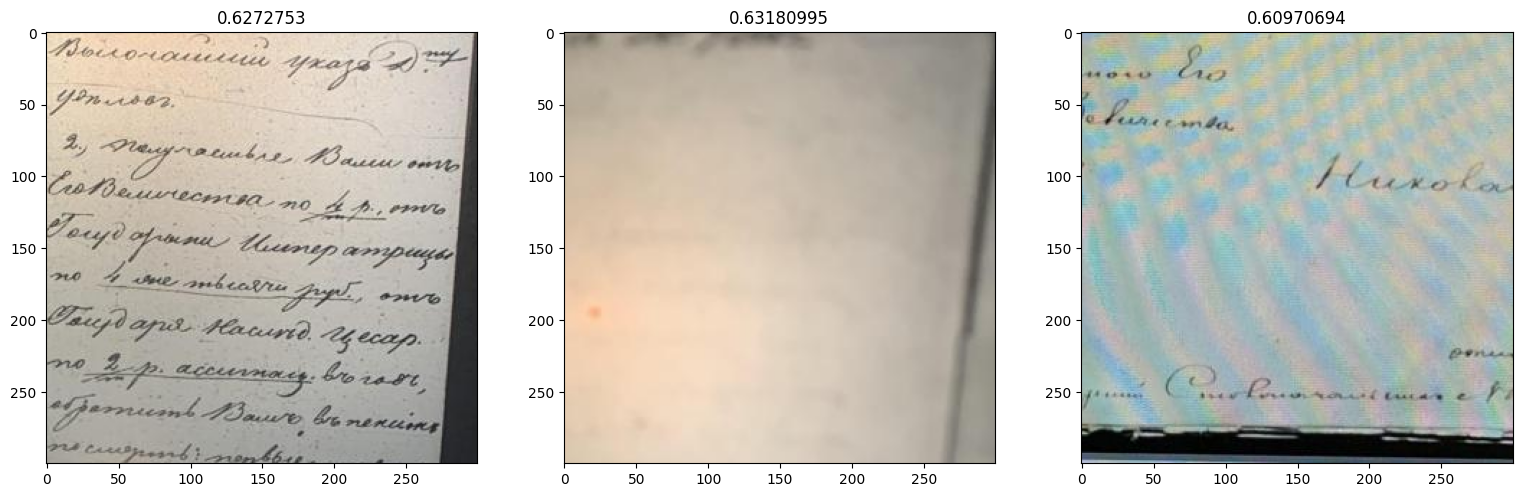

In [40]:
y_pred, _, y_prob, X = show_result(model, neg_dataset, 0.6, greater = True, col = 16, seed = 41)

In [41]:
s1 = [4, 5, 13, 20, 46, 53, 66, 89, 93, 100, 109, 128, 151, 163, 164, 170, 172, 173, 179, 181, 186, 187, 216, 223]
s2 = [14, 19, 21, 45, 60, 100, 112, 147, 163, 174, 175, 179, 180, 181, 186, 214]

l = sorted(list(set(s1) & set(s2)))
l

[100, 163, 179, 181, 186]

In [42]:
l = [21, 179, 180]

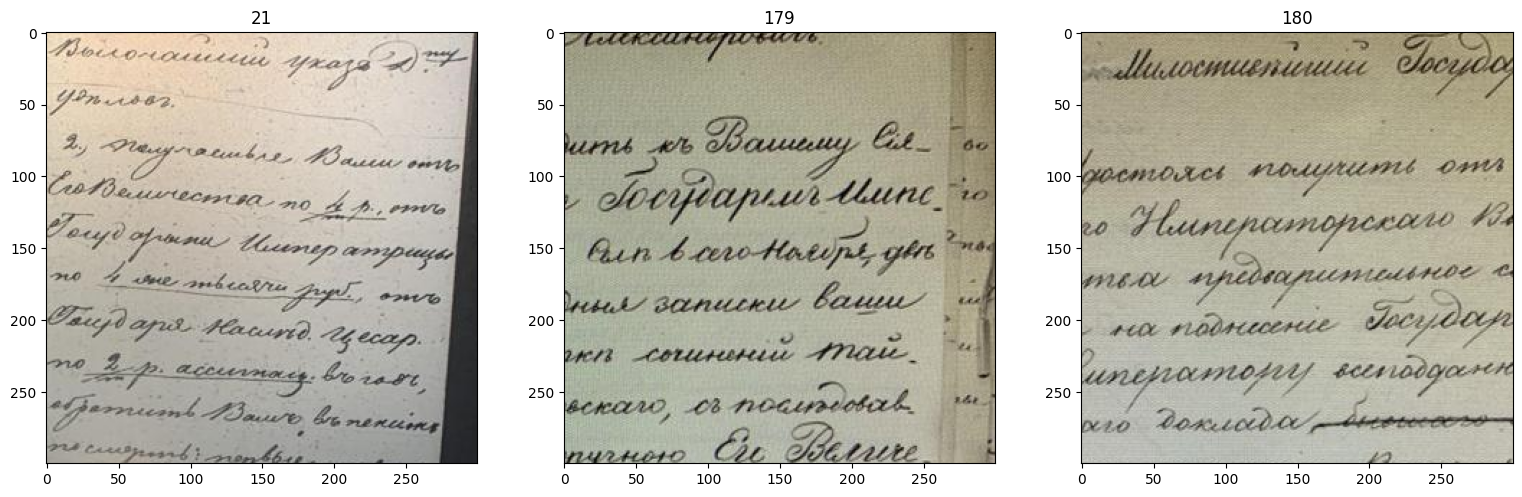

In [43]:
show_images(X[l], l, n = len(l))

In [44]:
y_pred, _, y_prob, X = show_result(model, neg_dataset, 0.3, greater = False, col = 24, seed = 41)

Output hidden; open in https://colab.research.google.com to view.

In [45]:
y_pred, _, y_prob, X = show_result(model, neg_dataset, 0, greater = True, col = 224, sort = True)

Output hidden; open in https://colab.research.google.com to view.

In [46]:
# neg = np.where(predicted_labels <= 0.8)[0]
# pos = np.where(predicted_labels > 0.8)[0]
# col = 8

In [47]:
# show_images(X[pos[:col]], predicted_labels[pos[:col]], n = col)